In [1]:
#Connect google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [2]:
#Import neccessary libs and packages
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [3]:
csv_df = pd.read_csv("/content/drive/My Drive/FYP/Colab Files/df_with_weather_traffic_data.csv")
print(csv_df.head())

   Unnamed: 0                 start_date                    station_name  \
0           0  2021-04-06T18:48:40+00:00        TOWN OF CARY / BOND PARK   
1           1  2021-04-06T16:44:39+00:00        TOWN OF CARY / BOND PARK   
2           2  2021-04-06T12:45:28+00:00  TOWN OF CARY / P2_DTCARYDEKCE2   
3           3  2021-04-05T21:58:48+00:00  TOWN OF CARY / P2_DTCARYDEKCE2   
4           4  2021-04-04T22:55:23+00:00     TOWN OF CARY / TOWNHALLEAST   

  charging_time_hh_mm_ss  energy_kwh            address_1  \
0               01:30:22      10.587  801 High House Road   
1               01:17:09       8.349  801 High House Road   
2               00:28:15       1.548        113 Walnut St   
3               01:08:22       6.558        113 Walnut St   
4               07:08:24      44.355  228 Ambassador Loop   

             address_2  city  state_province  zip_postal_code  ...  \
0  Bond Park Boathouse  Cary  North Carolina            27513  ...   
1  Bond Park Boathouse  Cary  North 

In [4]:
# Drop 'Unnamed: 0' and 'geopoint' columns
csv_df = csv_df.drop(['Unnamed: 0', 'geopoint'], axis=1)

In [5]:
print(csv_df)

                      start_date                    station_name  \
0      2021-04-06T18:48:40+00:00        TOWN OF CARY / BOND PARK   
1      2021-04-06T16:44:39+00:00        TOWN OF CARY / BOND PARK   
2      2021-04-06T12:45:28+00:00  TOWN OF CARY / P2_DTCARYDEKCE2   
3      2021-04-05T21:58:48+00:00  TOWN OF CARY / P2_DTCARYDEKCE2   
4      2021-04-04T22:55:23+00:00     TOWN OF CARY / TOWNHALLEAST   
...                          ...                             ...   
20137  2022-07-08T15:22:00+00:00     TOWN OF CARY / BOND PARK BH   
20138  2022-07-07T22:36:42+00:00    TOWN OF CARY / TOWN HALL-PWH   
20139  2022-07-07T16:54:26+00:00  TOWN OF CARY / DT DECK P3 WEST   
20140  2022-07-06T23:58:46+00:00   TOWN OF CARY / DT DECK P2 (1)   
20141  2022-07-06T20:14:36+00:00   TOWN OF CARY / DT DECK P2 (2)   

      charging_time_hh_mm_ss  energy_kwh            address_1  \
0                   01:30:22      10.587  801 High House Road   
1                   01:17:09       8.349  801 High Ho

In [6]:
missing_values = csv_df.isnull().sum()
print(missing_values)

start_date                   0
station_name                 0
charging_time_hh_mm_ss       0
energy_kwh                   0
address_1                    0
address_2                 9946
city                         0
state_province               0
zip_postal_code              0
fee                          0
model_number               731
latitude                     0
longitude                    0
tmin                         0
tmax                         0
tavg                         0
coco                      1623
user_latitude                0
user_longitude               0
length_m                     0
duration_s                   0
base_duration_s              0
dtype: int64


In [7]:
csv_df.drop(columns=['address_2'], inplace=True)
csv_df['model_number'].fillna('Unknown', inplace=True)
# Remove rows with null values in the 'coco' column
csv_df = csv_df.dropna(subset=['coco'])
# Verify that null values are removed
print(csv_df.isnull().sum())

start_date                0
station_name              0
charging_time_hh_mm_ss    0
energy_kwh                0
address_1                 0
city                      0
state_province            0
zip_postal_code           0
fee                       0
model_number              0
latitude                  0
longitude                 0
tmin                      0
tmax                      0
tavg                      0
coco                      0
user_latitude             0
user_longitude            0
length_m                  0
duration_s                0
base_duration_s           0
dtype: int64


<ipython-input-7-c7339ecaf564>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  csv_df['model_number'].fillna('Unknown', inplace=True)


In [8]:
csv_df['start_date'] = pd.to_datetime(csv_df['start_date'])

# Extract time-related features
csv_df['year'] = csv_df['start_date'].dt.year
csv_df['month'] = csv_df['start_date'].dt.month
csv_df['day'] = csv_df['start_date'].dt.day
csv_df['hour'] = csv_df['start_date'].dt.hour
csv_df['day_of_week'] = csv_df['start_date'].dt.dayofweek

# Convert 'charging_time_hh_mm_ss' to seconds
csv_df['charging_time_seconds'] = (
    pd.to_timedelta(csv_df['charging_time_hh_mm_ss']).dt.total_seconds()
)


In [9]:
csv_df['is_weekend'] = csv_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [10]:
label_encoder = LabelEncoder()
csv_df['station_name_encoded'] = label_encoder.fit_transform(csv_df['station_name'])


In [11]:
print(csv_df)

                     start_date                    station_name  \
0     2021-04-06 18:48:40+00:00        TOWN OF CARY / BOND PARK   
1     2021-04-06 16:44:39+00:00        TOWN OF CARY / BOND PARK   
2     2021-04-06 12:45:28+00:00  TOWN OF CARY / P2_DTCARYDEKCE2   
3     2021-04-05 21:58:48+00:00  TOWN OF CARY / P2_DTCARYDEKCE2   
4     2021-04-04 22:55:23+00:00     TOWN OF CARY / TOWNHALLEAST   
...                         ...                             ...   
20137 2022-07-08 15:22:00+00:00     TOWN OF CARY / BOND PARK BH   
20138 2022-07-07 22:36:42+00:00    TOWN OF CARY / TOWN HALL-PWH   
20139 2022-07-07 16:54:26+00:00  TOWN OF CARY / DT DECK P3 WEST   
20140 2022-07-06 23:58:46+00:00   TOWN OF CARY / DT DECK P2 (1)   
20141 2022-07-06 20:14:36+00:00   TOWN OF CARY / DT DECK P2 (2)   

      charging_time_hh_mm_ss  energy_kwh            address_1  city  \
0                   01:30:22      10.587  801 High House Road  Cary   
1                   01:17:09       8.349  801 High Ho

In [12]:
df = csv_df.drop(columns=['start_date', 'charging_time_hh_mm_ss', 'station_name', 'address_1', 'model_number',
                          'city', 'state_province', 'zip_postal_code', 'fee'])
print(df)

       energy_kwh   latitude  longitude  tmin  tmax    tavg  coco  \
0          10.587  35.781303 -78.825554  10.6  28.0  19.144   2.0   
1           8.349  35.781303 -78.825554  10.6  28.0  19.144   2.0   
2           1.548  35.785385 -78.779701  10.6  28.0  19.144   2.0   
3           6.558  35.785385 -78.779701   5.6  23.9  15.752   2.0   
4          44.355  35.789215 -78.778816   3.3  23.3  12.404   2.0   
...           ...        ...        ...   ...   ...     ...   ...   
20137       0.576  35.781303 -78.825554  24.4  32.2  27.068   3.0   
20138      22.864  35.789215 -78.778816  24.4  37.8  28.920   4.0   
20139       0.000  35.785282 -78.779282  24.4  37.8  28.920   4.0   
20140       5.267  35.785446 -78.779411  22.2  38.9  29.500   3.0   
20141       5.012  35.785385 -78.779701  22.2  38.9  29.500   3.0   

       user_latitude  user_longitude  length_m  duration_s  base_duration_s  \
0          35.773009      -78.818306      4645         457              448   
1          35

In [13]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop(columns=['energy_kwh'])
y = df['energy_kwh']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


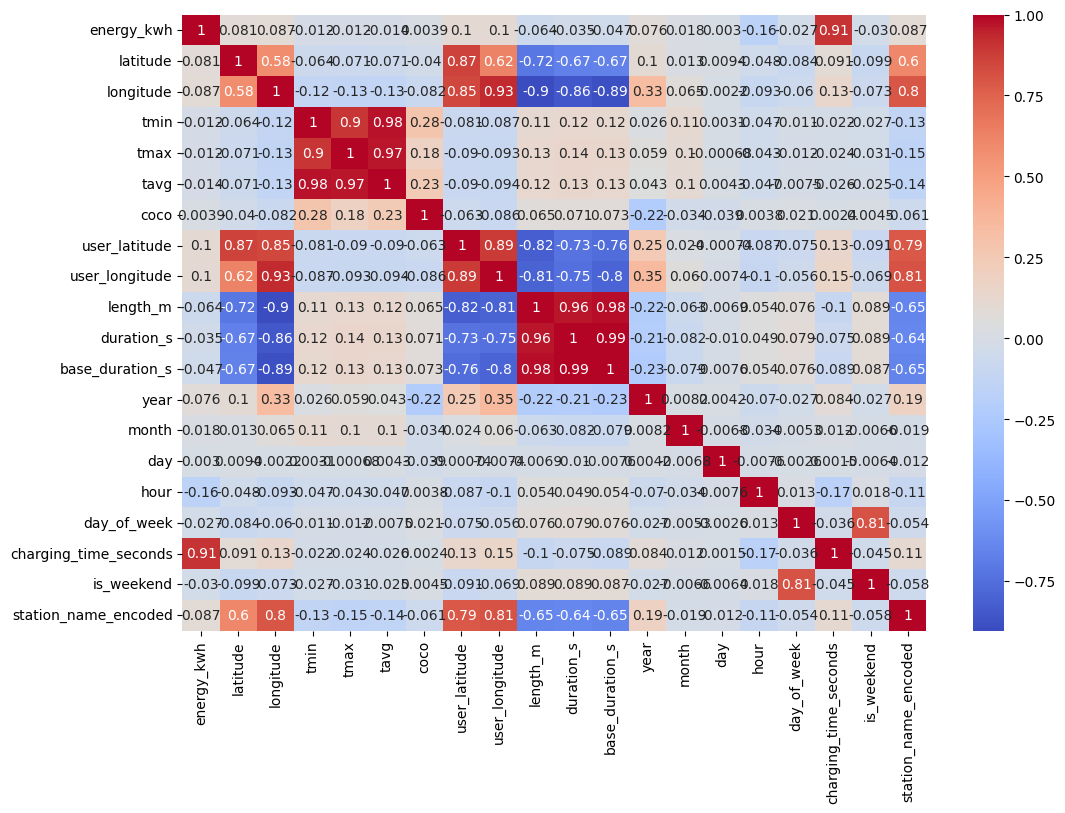

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [15]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)
importance = model.feature_importances_
for i, feature in enumerate(X.columns):
    print(f"{feature}: {importance[i]}")

latitude: 0.007195495336527135
longitude: 0.002426389255044437
tmin: 0.005109759705652349
tmax: 0.005787036980377854
tavg: 0.006663575279132921
coco: 0.003138553282980979
user_latitude: 0.01561705355144681
user_longitude: 0.030029574754143
length_m: 0.0013920568562269513
duration_s: 0.0013823337092826974
base_duration_s: 0.00116577586286936
year: 0.0046567709820370526
month: 0.004891684809213129
day: 0.007257363288937183
hour: 0.009316708761585055
day_of_week: 0.0037590290026414093
charging_time_seconds: 0.8712717231145313
is_weekend: 0.0004934763510559346
station_name_encoded: 0.01844563911631446


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [19]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [21]:
import pickle
model_pkl_file = "/content/drive/My Drive/FYP/Colab Files/random_forest_model_4.pkl"
with open(model_pkl_file, 'wb') as file:
    pickle.dump(best_model, file)

In [22]:
y_pred = best_model.predict(X_test)

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R² Score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 1.8021197232721382
Root Mean Squared Error (RMSE): 2.7667130542220364
R² Score: 0.927507246598903


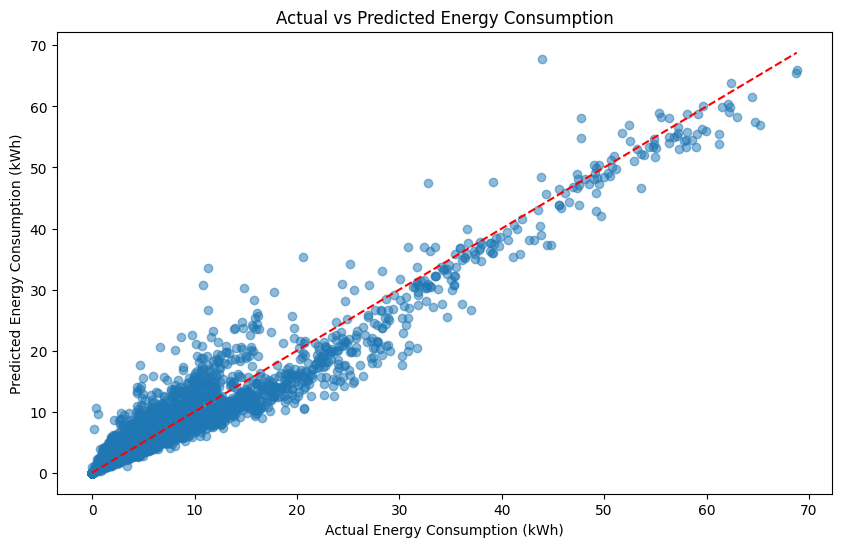

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Energy Consumption (kWh)")
plt.ylabel("Predicted Energy Consumption (kWh)")
plt.title("Actual vs Predicted Energy Consumption")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Convert scores to positive and calculate RMSE for each fold
rmse_scores = (-cv_scores)**0.5
print("RMSE for each fold:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))


RMSE for each fold: [2.6932229  3.00455909 5.55417641 2.87772662 2.76824334]
Mean RMSE: 3.3795856730062477


In [ ]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
import pickle
model_pkl_file = "/content/drive/My Drive/FYP/Colab Files/random_forest_model_3.pkl"
with open(model_pkl_file, 'wb') as file:
    pickle.dump(rf_model, file)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)


MAE: 1.8130582478401729
RMSE: 2.7833359596123772
R²: 0.9266335309618056


In [ ]:
# Display a sample of actual vs predicted values
for actual, predicted in zip(y_test[:10], y_pred[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")


Actual: 4.34, Predicted: 6.315409999999999
Actual: 0.087, Predicted: 0.04017999999999999
Actual: 0.0, Predicted: 0.0
Actual: 10.02, Predicted: 8.774140000000004
Actual: 3.785, Predicted: 2.8262600000000013
Actual: 7.61, Predicted: 6.27874
Actual: 2.66, Predicted: 3.556400000000001
Actual: 4.949, Predicted: 15.35698
Actual: 7.962, Predicted: 10.13759
Actual: 12.432, Predicted: 11.371120000000003


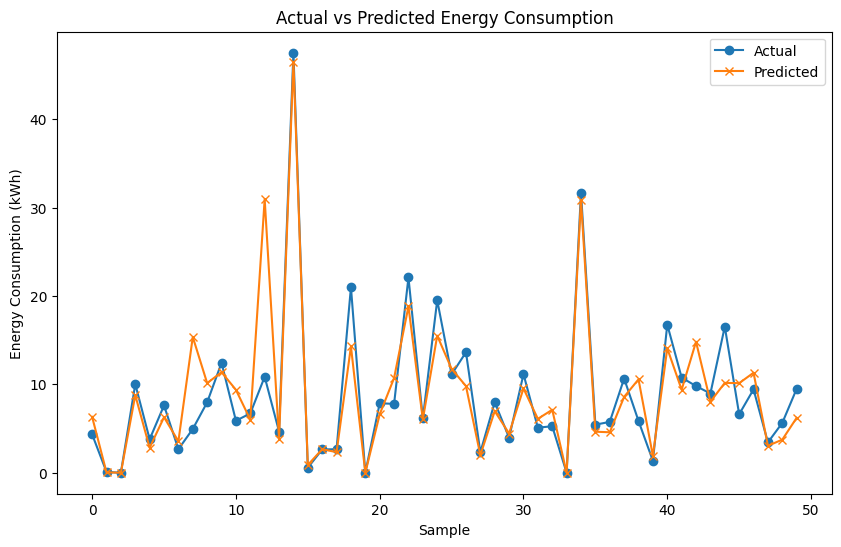

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:50], label='Actual', marker='o')
plt.plot(y_pred[:50], label='Predicted', marker='x')
plt.xlabel("Sample")
plt.ylabel("Energy Consumption (kWh)")
plt.title("Actual vs Predicted Energy Consumption")
plt.legend()
plt.show()


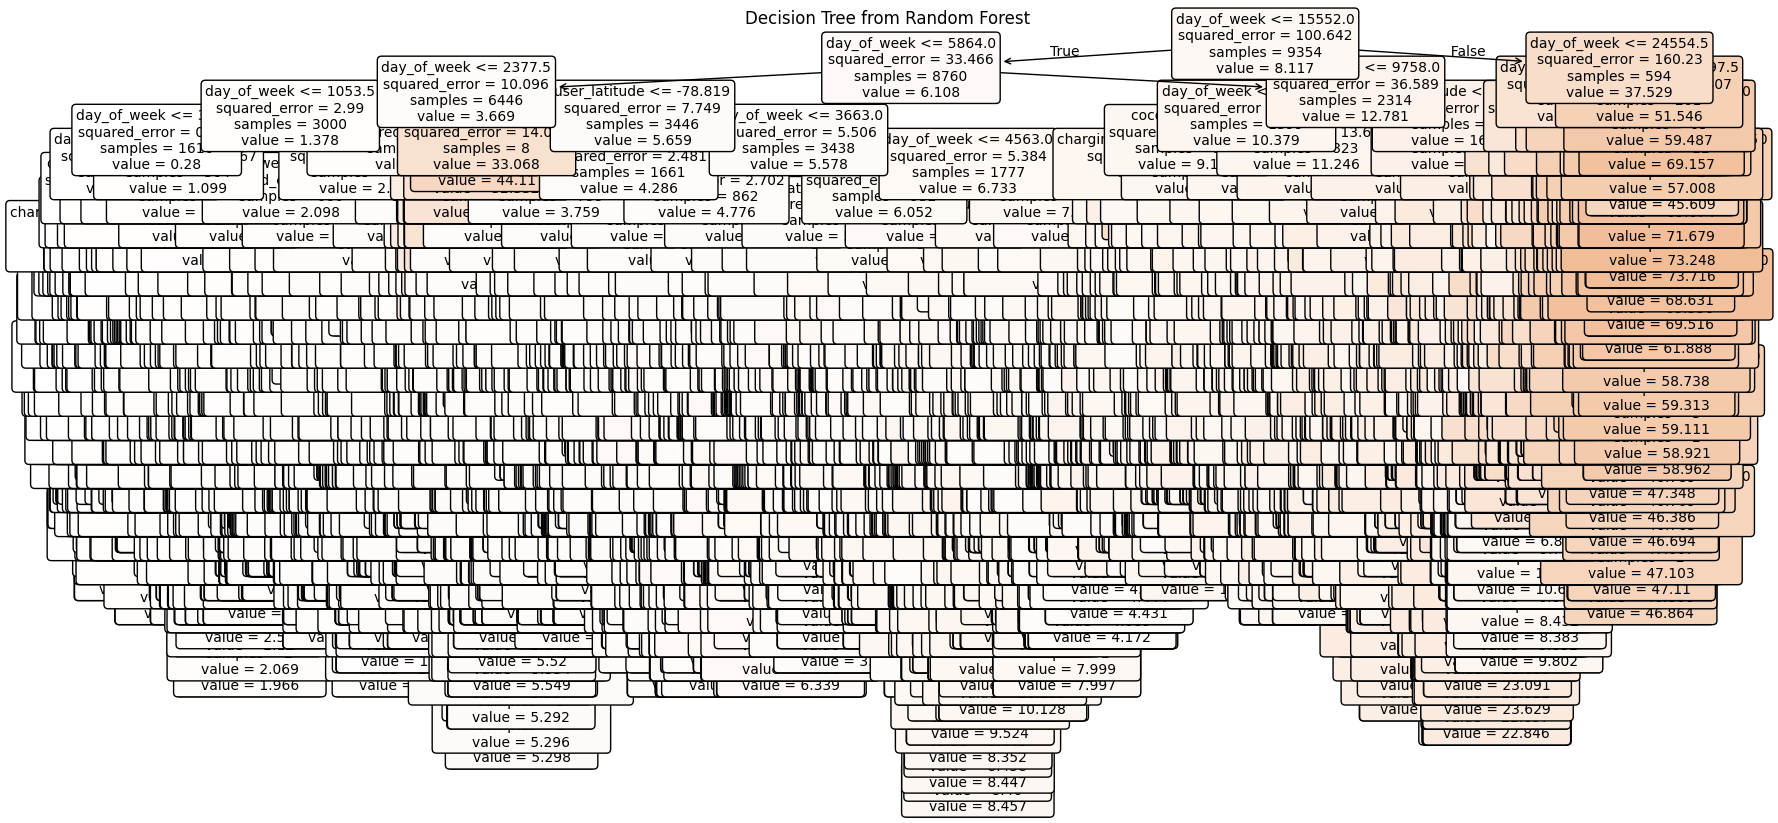

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming regressor is your trained Random Forest model
# Pick one tree from the forest, e.g., the first tree (index 0)
tree_to_plot = rf_model.estimators_[0]

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=df.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

In [ ]:
print(np.__version__)

1.26.4
